In [1]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '../src'))
	print(os.getcwd())
except:
	pass


/home/rv-hdoosterlinck/repos/unlearning/src


In [2]:
import os
import shutil
import sys
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from keras.utils import to_categorical
from network import basenet, get_multitask_network, get_numberonly_network, \
    get_multitask_network_gradflip
from utils import colors as all_colors_rgb, color_MNIST, compile_model, evaluate_results

%load_ext autoreload
%autoreload 2

/home/rv-hdoosterlinck/.conda/envs/ludwig/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rv-hdoosterlinck/.conda/envs/ludwig/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rv-hdoosterlinck/.conda/envs/ludwig/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/rv-hdoosterlinck/.c

In [3]:
import keras

gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
keras.backend.tensorflow_backend.set_session(sess)

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7342484607462452269
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10269580651508166715
physical_device_desc: "device: XLA_CPU device"
]


In [4]:
INITIAL_LR = 1e-4
EPOCHS = 50
PATIENCE = EPOCHS  # no early stopping here
BIAS = 0.9
GRADFLIP_LAMBDA = .1
DATA_FOLDER = '../data'
LOSS = 'categorical_crossentropy'
N = 200

# choose some colors
colors = {0: 'dark red',
          1: 'navy',
          2: 'gold',
          3: 'aqua',
          4: 'indigo',
          5: 'deep pink',
          6: 'chocolate',
          7: 'honeydew',
          8: 'dark violet',
          9: 'beige'
          }
colors_inv = {v: k for k, v in colors.items()}
colors_rgb = {k: all_colors_rgb[v] for k, v in colors.items()}
classes = list(colors.keys())

## Color-biased MNIST

In [5]:
# DATA
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)

x_train_color, y_train_color = color_MNIST(zip(x_train, y_train), colors, colors_rgb, bias=BIAS)
x_test_color, y_test_color = color_MNIST(zip(x_test, y_test), colors, colors_rgb, bias=0)
x_test_color_ref, y_test_color_ref = color_MNIST(zip(x_test, y_test), colors, colors_rgb, bias=BIAS)

y_train_color_onehot = to_categorical([colors_inv[c] for c in y_train_color])
y_train_multi = {'color': y_train_color_onehot, 'number': y_train_onehot}

In [6]:
# write away some results to jpg for inspection
shutil.rmtree(DATA_FOLDER)
for f in ['train', 'test']:
    [os.makedirs(os.path.join(DATA_FOLDER, f, str(label)), exist_ok=True)
     for label in classes]
    [os.makedirs(os.path.join(DATA_FOLDER, f, str(label)), exist_ok=True)
     for label in classes]

for i in range(N):
    path = os.path.join(DATA_FOLDER, 'train', str(y_train[i]), str(i)+'.jpg')
    ret = cv2.imwrite(path, x_train_color[i])
    assert ret

for i in range(N):
    path = os.path.join(DATA_FOLDER, 'test', str(y_test[i]), str(i)+'.jpg')
    ret = cv2.imwrite(path, x_test_color[i])
    assert ret


 ## train: number only, confirm bias

In [7]:
simplenet = basenet(input_shape=(28, 28, 3), n_conv=3,
                    init_filter_size=20, dropout_rate=0)
model_number = get_numberonly_network(backbone=simplenet)
model_number, callbacks = compile_model(model_number, 'mnist_number',
                                        loss=LOSS,  initial_lr=INITIAL_LR, patience=PATIENCE)
model_number.fit(x_train_color, y_train_onehot, validation_split=.2,
                 epochs=EPOCHS, callbacks=callbacks)





Train on 48000 samples, validate on 12000 samples


Epoch 1/50
48000/48000 [==============================] - 10s 215us/step - loss: 1.5641 - acc: 0.5191 - val_loss: 1.1268 - val_acc: 0.7001

Epoch 2/50
48000/48000 [==============================] - 10s 213us/step - loss: 0.8683 - acc: 0.7882 - val_loss: 0.6855 - val_acc: 0.8863
Epoch 3/50
48000/48000 [==============================] - 13s 263us/step - loss: 0.6144 - acc: 0.8918 - val_loss: 0.5439 - val_acc: 0.8987
Epoch 4/50
48000/48000 [==============================] - 12s 256us/step - loss: 0.5061 - acc: 0.9009 - val_loss: 0.4616 - val_acc: 0.9068
Epoch 5/50
48000/48000 [==============================] - 10s 218us/step - loss: 0.4448 - acc: 0.9066 - val_loss: 0.4059 - val_acc: 0.9136
Epoch 6/50
48000/48000 [==============================] - 11s 239us/step - loss: 0.4012 - acc: 0.9121 - val_loss: 0.3899 - val_acc: 0.9107
Epoch 7/50
48000/48000 [==============================] - 11s 233us/step - loss: 0.3685 - acc: 0.9159 - val_los

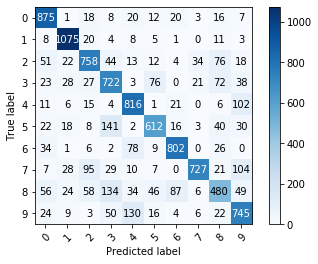

Accuracy: 76.12%
Per class statistics:
  - 0: precision 78.76%, recall 89.29%
  - 1: precision 88.70%, recall 94.71%
  - 2: precision 75.20%, recall 73.45%
  - 3: precision 63.44%, recall 71.49%
  - 4: precision 73.25%, recall 83.10%
  - 5: precision 76.88%, recall 68.61%
  - 6: precision 83.98%, recall 83.72%
  - 7: precision 90.88%, recall 70.72%
  - 8: precision 62.34%, recall 49.28%
  - 9: precision 67.97%, recall 73.84%


In [8]:
# Without bias
y_pred = np.argmax(model_number.predict(x_test_color), axis=1)
evaluate_results(y_test, y_pred, classes)


 Our model has become worse in predicting the number.


### train: Gradient Reversal
 In https://github.com/feidfoe/learning-not-to-learn/blob/master/trainer.py we see the authors train with a minimax game and gradient reversal.

 In essence, this means the head for color still tries to extract color info from the shared embedding, but during backprop we flip the gradient between the start of the color head and the embedding layer, meaning the shared weights move away from allowing encoding color information.

 Let's try the gradient reversal.

In [9]:
simplenet = basenet(input_shape=(28, 28, 3), n_conv=3,
                    init_filter_size=20, dropout_rate=0)

In [10]:
model_gradflip = get_multitask_network_gradflip(simplenet, gradflip_lambda=GRADFLIP_LAMBDA)

LOSS = 'categorical_crossentropy'
loss_weights = {
    "number": 1,
    "color": 1
}

model_gradflip, callbacks = compile_model(model_gradflip, 'mnist_number_color', LOSS,
                                          loss_weights=loss_weights, initial_lr=INITIAL_LR, patience=PATIENCE)
model_gradflip.fit(x_train_color, y_train_multi, validation_split=.2,
                   epochs=EPOCHS, callbacks=callbacks)

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 13s 274us/step - loss: 3.6004 - number_loss: 1.0521 - color_loss: 2.5483 - number_acc: 0.7315 - color_acc: 0.1852 - val_loss: 2.5036 - val_number_loss: 0.6230 - val_color_loss: 1.8806 - val_number_acc: 0.8729 - val_color_acc: 0.2948
Epoch 2/50
48000/48000 [==============================] - 13s 274us/step - loss: 2.1653 - number_loss: 0.5470 - color_loss: 1.6183 - number_acc: 0.8866 - color_acc: 0.3721 - val_loss: 1.9538 - val_number_loss: 0.4867 - val_color_loss: 1.4670 - val_number_acc: 0.8983 - val_color_acc: 0.4335
Epoch 3/50
48000/48000 [==============================] - 13s 261us/step - loss: 1.8024 - number_loss: 0.4504 - color_loss: 1.3520 - number_acc: 0.9026 - color_acc: 0.4915 - val_loss: 1.6407 - val_number_loss: 0.4304 - val_color_loss: 1.2103 - val_number_acc: 0.9061 - val_color_acc: 0.5678
Epoch 4/50
48000/48000 [==============================] - 13s 268us/step - lo

Epoch 29/50
48000/48000 [==============================] - 11s 237us/step - loss: 1.1268 - number_loss: 0.1280 - color_loss: 0.9988 - number_acc: 0.9626 - color_acc: 0.7201 - val_loss: 1.0369 - val_number_loss: 0.1267 - val_color_loss: 0.9102 - val_number_acc: 0.9648 - val_color_acc: 0.7456
Epoch 30/50
48000/48000 [==============================] - 11s 226us/step - loss: 0.9369 - number_loss: 0.1230 - color_loss: 0.8139 - number_acc: 0.9644 - color_acc: 0.7887 - val_loss: 0.8592 - val_number_loss: 0.1199 - val_color_loss: 0.7392 - val_number_acc: 0.9678 - val_color_acc: 0.8217
Epoch 31/50
48000/48000 [==============================] - 11s 238us/step - loss: 0.8239 - number_loss: 0.1143 - color_loss: 0.7096 - number_acc: 0.9670 - color_acc: 0.8232 - val_loss: 0.8029 - val_number_loss: 0.1056 - val_color_loss: 0.6974 - val_number_acc: 0.9712 - val_color_acc: 0.8363
Epoch 32/50
48000/48000 [==============================] - 11s 230us/step - loss: 0.8224 - number_loss: 0.1115 - color_loss:

 Now, lets predict on the inconsistently colored testset

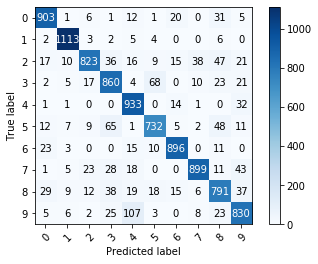

Accuracy: 87.80%
Per class statistics:
  - 0: precision 90.75%, recall 92.14%
  - 1: precision 95.95%, recall 98.06%
  - 2: precision 91.96%, recall 79.75%
  - 3: precision 81.52%, recall 85.15%
  - 4: precision 82.57%, recall 95.01%
  - 5: precision 86.63%, recall 82.06%
  - 6: precision 92.85%, recall 93.53%
  - 7: precision 93.26%, recall 87.45%
  - 8: precision 79.82%, recall 81.21%
  - 9: precision 83.00%, recall 82.26%


In [11]:
# no consistent coloring in the testset, contrary to the trainingset
# todo: how are we guaranteed of the order of outputs?
y_pred_number, y_pred_color = model_gradflip.predict(x_test_color)
y_pred_number = np.argmax(y_pred_number, axis=1)
evaluate_results(y_test, y_pred_number, classes)


## Conclusion

Following settings:  
INITIAL_LR = 1e-4  
EPOCHS = 50  
PATIENCE = EPOCHS  
BIAS = 0.9  
GRADFLIP_LAMBDA = .1  

Our testset accuracy in predicting the number went up from 84.33 to 90.4 percent, which is pretty decent. 

 # Notes:
 * Bias cannot be set to 1. If it is 1, color and number information align exactly and the two heads fight for keeping/destroying that information, without being able to nuance. Noisy bias ensures that there is indeed color info in the embedding, **separable** from number info.
 * Use a more powerful color branch (more dense layers) than the number branch so that simple hiding of color info in the embedding isn't enough.